In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import timm

In [11]:
# Load and preprocess the image
image = data.astronaut()
transform = transforms.ToTensor()
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Load a pretrained model from timm for feature extraction
model_name = 'resnet18'
pretrained_model = timm.create_model(model_name, pretrained=True)
pretrained_model.eval()

# Extract features using the pretrained model
with torch.no_grad():
    features = pretrained_model.forward_features(image_tensor)

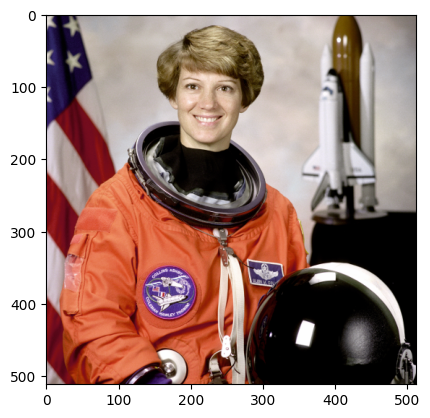

In [12]:
plt.imshow(image)

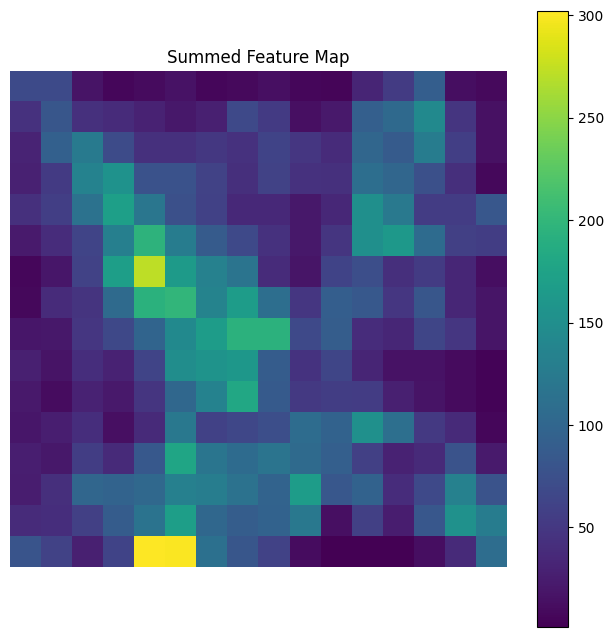

In [13]:
def sum_feature_maps(features):
    """
    Sum the feature maps across the channel dimension while retaining spatial dimensions.

    Parameters:
    features (torch.Tensor): The feature maps.

    Returns:
    numpy.ndarray: The summed feature map.
    """
    # Sum across the channel dimension
    summed_feature_map = features.sum(dim=1)  # Sum across channels
    return summed_feature_map.squeeze().cpu().numpy()  # Remove batch dimension and convert to numpy

# Ensure feature maps have spatial dimensions
if features.dim() == 4:  # [batch_size, channels, height, width]
    summed_feature_map = sum_feature_maps(features)
else:
    raise ValueError("Unexpected feature map dimensions")

# Plot the summed feature map
plt.figure(figsize=(8, 8))
plt.imshow(summed_feature_map, cmap='viridis')  # Display the summed feature map
plt.title('Summed Feature Map')
plt.colorbar()
plt.axis('off')
plt.show()


ConvTranspose2d

Epoch [100/1000], Loss: 0.1504
Epoch [200/1000], Loss: 0.1041
Epoch [300/1000], Loss: 0.0826
Epoch [400/1000], Loss: 0.0694
Epoch [500/1000], Loss: 0.0604
Epoch [600/1000], Loss: 0.0543
Epoch [700/1000], Loss: 0.0485
Epoch [800/1000], Loss: 0.0445
Epoch [900/1000], Loss: 0.0413
Epoch [1000/1000], Loss: 0.0383


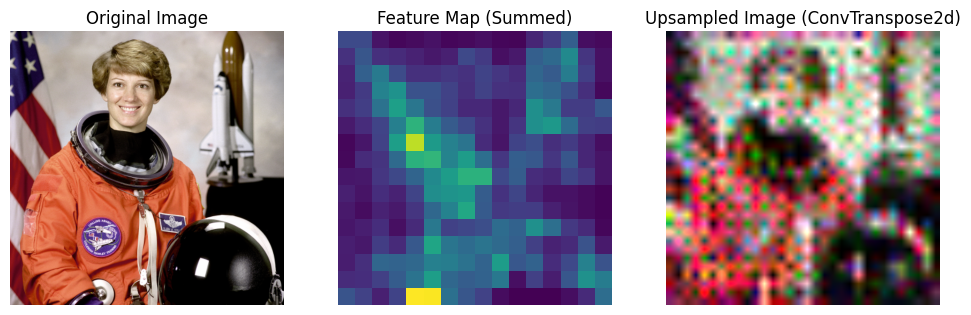

In [14]:
class UNetDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetDecoder, self).__init__()
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.decoder(x)

# Extracting from pretrained model (ResNet)
with torch.no_grad():
    features = pretrained_model.forward_features(image_tensor)
    features = features[0]
    features = features.unsqueeze(0)

unet_model_decoder = UNetDecoder(in_channels=features.size(1), out_channels=3)

criterion = nn.MSELoss()
optimizer = optim.Adam(unet_model_decoder.parameters(), lr=1e-4)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    unet_model_decoder.train()

    # Forward pass
    output = unet_model_decoder(features)

    # Ensure output size matches original image size
    if output.size(2) != image_tensor.size(2) or output.size(3) != image_tensor.size(3):
        output = F.interpolate(output, size=(image_tensor.size(2), image_tensor.size(3)), mode='bilinear', align_corners=False)

    # loss
    loss = criterion(output, image_tensor)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

def convert_to_rgb(tensor):
    tensor = torch.clamp(tensor, 0, 1)
    return tensor.permute(1, 2, 0).cpu().numpy()

output_rgb = convert_to_rgb(output[0].detach())

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(convert_to_rgb(image_tensor[0]))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Feature Map (Summed)')
plt.imshow(summed_feature_map, cmap='viridis')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Upsampled Image (ConvTranspose2d)')
plt.imshow(output_rgb)
plt.axis('off')

plt.show()

INTERPOLATION

Epoch [100/1000], Loss: 0.0535
Epoch [200/1000], Loss: 0.0406
Epoch [300/1000], Loss: 0.0349
Epoch [400/1000], Loss: 0.0313
Epoch [500/1000], Loss: 0.0288
Epoch [600/1000], Loss: 0.0271
Epoch [700/1000], Loss: 0.0258
Epoch [800/1000], Loss: 0.0248
Epoch [900/1000], Loss: 0.0239
Epoch [1000/1000], Loss: 0.0231


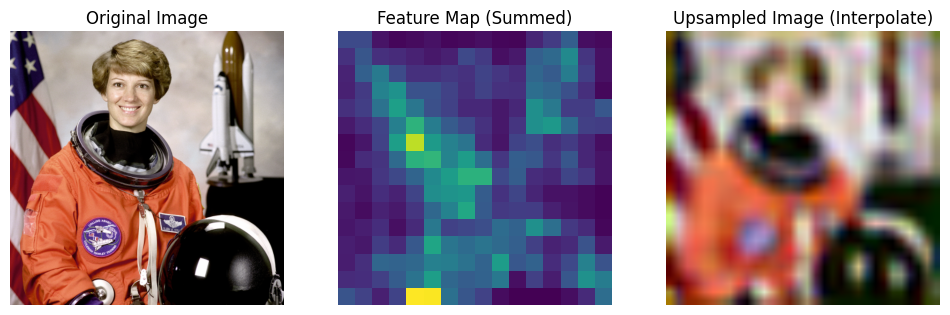

In [18]:
pretrained_model = timm.create_model('resnet18', pretrained=True)
pretrained_model.eval()

image = data.astronaut()
image = transforms.ToTensor()(image).unsqueeze(0)

with torch.no_grad():
    features = pretrained_model.forward_features(image)
    features = features[0]
    features = features.unsqueeze(0)

class UNetDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetDecoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

unet_model_decoder = UNetDecoder(in_channels=features.size(1), out_channels=3)

criterion = nn.MSELoss()
optimizer = optim.Adam(unet_model_decoder.parameters(), lr=1e-4)

num_epochs = 1000
for epoch in range(num_epochs):
    unet_model_decoder.train()
    output = unet_model_decoder(features)

    if output.size(2) != image.size(2) or output.size(3) != image.size(3):
        output = F.interpolate(output, size=(image.size(2), image.size(3)), mode='bilinear', align_corners=False)

    loss = criterion(output, image)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

def convert_to_rgb(tensor):
    tensor = torch.clamp(tensor, 0, 1)
    return tensor.permute(1, 2, 0).cpu().numpy()

output_rgb = convert_to_rgb(output[0].detach())

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(convert_to_rgb(image[0]))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Feature Map (Summed)')
summed_feature_map = features[0].mean(dim=0).cpu().numpy()
plt.imshow(summed_feature_map, cmap='viridis')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Upsampled Image (Interpolate)')
plt.imshow(output_rgb)
plt.axis('off')

plt.show()

PixelShuffle

Epoch [100/1000], Loss: 0.0649
Epoch [200/1000], Loss: 0.0423
Epoch [300/1000], Loss: 0.0328
Epoch [400/1000], Loss: 0.0276
Epoch [500/1000], Loss: 0.0243
Epoch [600/1000], Loss: 0.0220
Epoch [700/1000], Loss: 0.0204
Epoch [800/1000], Loss: 0.0192
Epoch [900/1000], Loss: 0.0183
Epoch [1000/1000], Loss: 0.0176


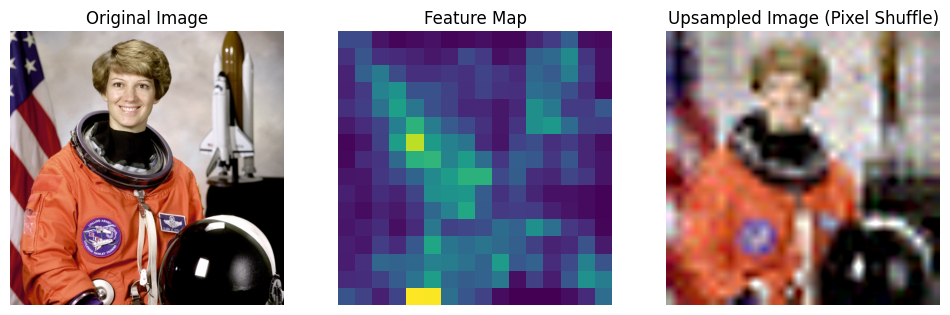

In [19]:
model_name = 'efficientnet_b0'
pretrained_model = timm.create_model(model_name, pretrained=True)
pretrained_model.eval()

with torch.no_grad():
    features = pretrained_model.forward_features(image_tensor)
    features = features[0]  # Drop the batch dimension
    features = features.unsqueeze(0)  # Add batch dimension

class PixelShuffle(nn.Module):
    def __init__(self, in_channels, out_channels, upscale_factor=2):
        super(PixelShuffle, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels * (upscale_factor ** 2), kernel_size=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        return x

class UNetPixelShuffle(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetPixelShuffle, self).__init__()
        self.decoder = PixelShuffle(in_channels=in_channels, out_channels=out_channels, upscale_factor=2)

    def forward(self, x):
        return self.decoder(x)

unet_model_pixelshuffle = UNetPixelShuffle(in_channels=features.size(1), out_channels=3)


criterion = nn.MSELoss()
optimizer = optim.Adam(unet_model_pixelshuffle.parameters(), lr=1e-4)

# Training loop
num_epochs = 1000  # Number of training epochs
for epoch in range(num_epochs):
    unet_model_pixelshuffle.train()

    # Forward pass
    output = unet_model_pixelshuffle(features)

    if output.size(2) != image_tensor.size(2) or output.size(3) != image_tensor.size(3):
        output = F.interpolate(output, size=(image_tensor.size(2), image_tensor.size(3)), mode='bilinear', align_corners=False)

    loss = criterion(output, image_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

def convert_to_rgb(tensor):
    tensor = torch.clamp(tensor, 0, 1)
    return tensor.permute(1, 2, 0).cpu().numpy()

output_rgb = convert_to_rgb(output[0].detach())


plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(convert_to_rgb(image_tensor[0]))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Feature Map')
plt.imshow(summed_feature_map, cmap='viridis')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Upsampled Image (Pixel Shuffle)')
plt.imshow(output_rgb)
plt.axis('off')

plt.show()

PixelShuffle with initialization

Epoch [100/1000], Loss: 0.5952
Epoch [200/1000], Loss: 0.2649
Epoch [300/1000], Loss: 0.1607
Epoch [400/1000], Loss: 0.1132
Epoch [500/1000], Loss: 0.0872
Epoch [600/1000], Loss: 0.0711
Epoch [700/1000], Loss: 0.0601
Epoch [800/1000], Loss: 0.0521
Epoch [900/1000], Loss: 0.0461
Epoch [1000/1000], Loss: 0.0414


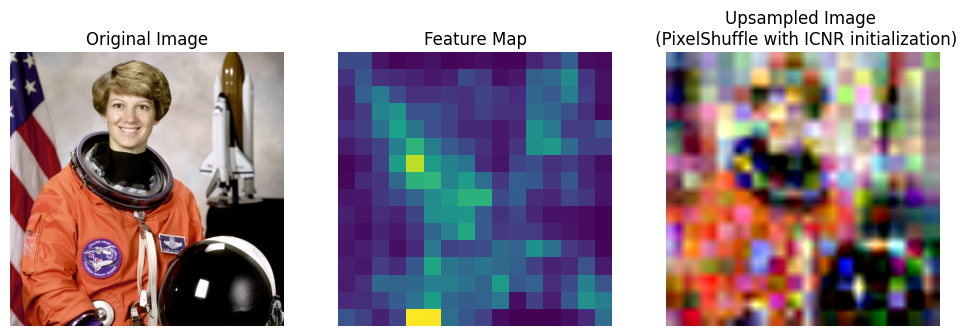

In [20]:
# src of icnr_init  was from rsna's 1st place solution
def icnr_init(tensor, upscale_factor=2, initializer=nn.init.kaiming_normal_):
    """
    ICNR initialization for PixelShuffle layer
    """
    new_shape = [int(tensor.shape[0] / (upscale_factor ** 2))] + list(tensor.shape[1:])
    subkernel = torch.zeros(new_shape)
    initializer(subkernel)
    subkernel = subkernel.transpose(0, 1)
    subkernel = subkernel.contiguous().view(subkernel.shape[0], subkernel.shape[1], -1)
    kernel = subkernel.repeat(1, 1, upscale_factor ** 2)
    kernel = kernel.contiguous().view([tensor.shape[1], tensor.shape[0]] + list(tensor.shape[2:]))
    tensor.data.copy_(kernel.transpose(0, 1))

class PixelShuffleICNR(nn.Module):
    def __init__(self, in_channels, out_channels, upscale_factor=2):
        super(PixelShuffleICNR, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels * (upscale_factor ** 2), kernel_size=1)
        icnr_init(self.conv.weight, upscale_factor)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        return x

class UNetPixelShuffleICNR(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetPixelShuffleICNR, self).__init__()
        # Decoder
        self.decoder = PixelShuffleICNR(in_channels=in_channels, out_channels=out_channels, upscale_factor=2)

    def forward(self, x):
        return self.decoder(x)

model_name = 'efficientnet_b0'  # Example model
pretrained_model = timm.create_model(model_name, pretrained=True)
pretrained_model.eval()

with torch.no_grad():
    features = pretrained_model.forward_features(image_tensor)
    # Reshape features to match expected input for UNetDecoder
    features = features[0]  # Drop the batch dimension
    features = features.unsqueeze(0)  # Add batch dimension

# Define the U-Net model with PixelShuffleICNR decoder
unet_model_pixelshuffle_icnr = UNetPixelShuffleICNR(in_channels=features.size(1), out_channels=3)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # RMSE can be computed as sqrt(MSE) if needed
optimizer = optim.Adam(unet_model_pixelshuffle_icnr.parameters(), lr=1e-4)

# Training loop
num_epochs = 1000  # Number of training epochs
for epoch in range(num_epochs):
    unet_model_pixelshuffle_icnr.train()

    # Forward pass
    output = unet_model_pixelshuffle_icnr(features)
    if output.size(2) != image_tensor.size(2) or output.size(3) != image_tensor.size(3):
        output = F.interpolate(output, size=(image_tensor.size(2), image_tensor.size(3)), mode='bilinear', align_corners=False)

    loss = criterion(output, image_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

def convert_to_rgb(tensor):
    # Convert tensor to numpy and clamp values to [0, 1]
    tensor = torch.clamp(tensor, 0, 1)
    return tensor.permute(1, 2, 0).cpu().numpy()

output_rgb = convert_to_rgb(output[0].detach())

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(convert_to_rgb(image_tensor[0]))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Feature Map')
plt.imshow(summed_feature_map, cmap='viridis')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Upsampled Image \n (PixelShuffle with ICNR initialization)')
plt.imshow(output_rgb)
plt.axis('off')

plt.show()
